In [1]:
#Data cleanup here

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import csv
import json
from bokeh.io import show
from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider)
from bokeh.layouts import column, row, widgetbox
from bokeh.palettes import brewer
from bokeh.plotting import figure
import requests
import seaborn as sns
import geopandas as gpd
import time

In [2]:
# Pull csv using URL of dataset uploaded to repo

url = 'https://raw.githubusercontent.com/calderon0423/Commitment-Issues/master/Dataset/'

all_homes = pd.read_csv(f'{url}State_MedianRentalPrice_AllHomes.csv')
del all_homes['Unnamed: 0']
all_homes.head()

,RegionName,SizeRank,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,...,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12
0,California,1,NaN,NaN,2400.0,2400.0,2400.0,2495.0,2500.0,2595.0,...,2750.0,2800,2800.0,2800.0,2800.0,2850,2800.0,2800.0,2800.0,2800.0
1,Texas,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1550.0,1575,1595.0,1595.0,1600.0,1595,1590.0,1550.0,1550.0,1550.0
2,New York,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3200.0,3495,3299.0,3295.0,3200.0,3395,3250.0,2950.0,3000.0,3200.0
3,Florida,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1850.0,1850,1850.0,1845.0,1800.0,1800,1800.0,1800.0,1795.0,1790.0
4,Illinois,5,1575.0,1500.0,1500.0,1500.0,1500.0,1500.0,1550.0,1520.0,...,1600.0,1600,1600.0,1642.5,1647.0,1650,1625.0,1600.0,1595.0,1590.0


In [3]:
# Convert the data to long form
all_homes_long = pd.melt(all_homes, id_vars=['RegionName', 'SizeRank'])

#Rename columns
all_homes_long.columns = ['RegionName', 'SizeRank', 'Time', 'Value']

all_homes_long['Time'] = pd.to_datetime(all_homes_long['Time']) 
all_homes_long['Year'] = pd.DatetimeIndex(all_homes_long['Time']).year
all_homes_long['Month'] = pd.DatetimeIndex(all_homes_long['Time']).month

missing_months = all_homes_long.groupby(['RegionName', 'Year'])['Value'].count()
missing_months = missing_months.reset_index()
missing_months['Missing'] = 12 - missing_months['Value']
missing_months.loc[missing_months['Missing'] > 0]

,RegionName,Year,Value,Missing
0,Alabama,2010,8,4
10,Alaska,2010,0,12
11,Alaska,2011,11,1
20,Arizona,2010,10,2
30,Arkansas,2010,11,1
...,...,...,...,...
500,Wyoming,2010,0,12
501,Wyoming,2011,0,12
502,Wyoming,2012,0,12
503,Wyoming,2013,0,12


In [4]:
#Filter for years 2016 and 2017
all_homes_long = all_homes_long.loc[all_homes_long['Year'].isin(['2015', '2016', '2017', '2018'])]

#Drop NAs after filtering so NAs in previous years don't affect
all_homes_long = all_homes_long.dropna()

#View counts for each state to exclude states with less than 24 months of data
all_homes_long.RegionName.value_counts()

Utah                    48
Wisconsin               48
Mississippi             48
Oklahoma                48
Oregon                  48
Nevada                  48
Illinois                48
Wyoming                 48
New Hampshire           48
Iowa                    48
Kentucky                48
West Virginia           48
Montana                 48
Ohio                    48
Maryland                48
Maine                   48
New Mexico              48
Washington              48
Hawaii                  48
Arkansas                48
California              48
Indiana                 48
South Carolina          48
New York                48
Alaska                  48
Alabama                 48
Minnesota               48
Missouri                48
Tennessee               48
Connecticut             48
Pennsylvania            48
District of Columbia    48
Florida                 48
North Carolina          48
Rhode Island            48
Idaho                   48
Colorado                48
S

In [5]:
#Exclude Nebraska, North Dakota and Puerto Rico as they have less than 24 months of data
all_homes_long = all_homes_long.loc[~all_homes_long.RegionName.isin(['Puerto Rico', 'Nebraska', 'North Dakota'])]

all_homes_long


,RegionName,SizeRank,Time,Value,Year,Month
3060,California,1,2015-01-01,2100.0,2015,1
3061,Texas,2,2015-01-01,1350.0,2015,1
3062,New York,3,2015-01-01,3000.0,2015,1
3063,Florida,4,2015-01-01,1550.0,2015,1
3064,Illinois,5,2015-01-01,1550.0,2015,1
...,...,...,...,...,...,...
5501,Delaware,45,2018-12-01,1400.0,2018,12
5502,South Dakota,46,2018-12-01,1112.5,2018,12
5503,Alaska,47,2018-12-01,1600.0,2018,12
5505,District of Columbia,49,2018-12-01,2600.0,2018,12


In [6]:
#Convert Time to proper date-time

all_homes_long.to_csv('all_homes_long.csv')

all_homes_long


,RegionName,SizeRank,Time,Value,Year,Month
3060,California,1,2015-01-01,2100.0,2015,1
3061,Texas,2,2015-01-01,1350.0,2015,1
3062,New York,3,2015-01-01,3000.0,2015,1
3063,Florida,4,2015-01-01,1550.0,2015,1
3064,Illinois,5,2015-01-01,1550.0,2015,1
...,...,...,...,...,...,...
5501,Delaware,45,2018-12-01,1400.0,2018,12
5502,South Dakota,46,2018-12-01,1112.5,2018,12
5503,Alaska,47,2018-12-01,1600.0,2018,12
5505,District of Columbia,49,2018-12-01,2600.0,2018,12


<IPython.core.display.Javascript object>


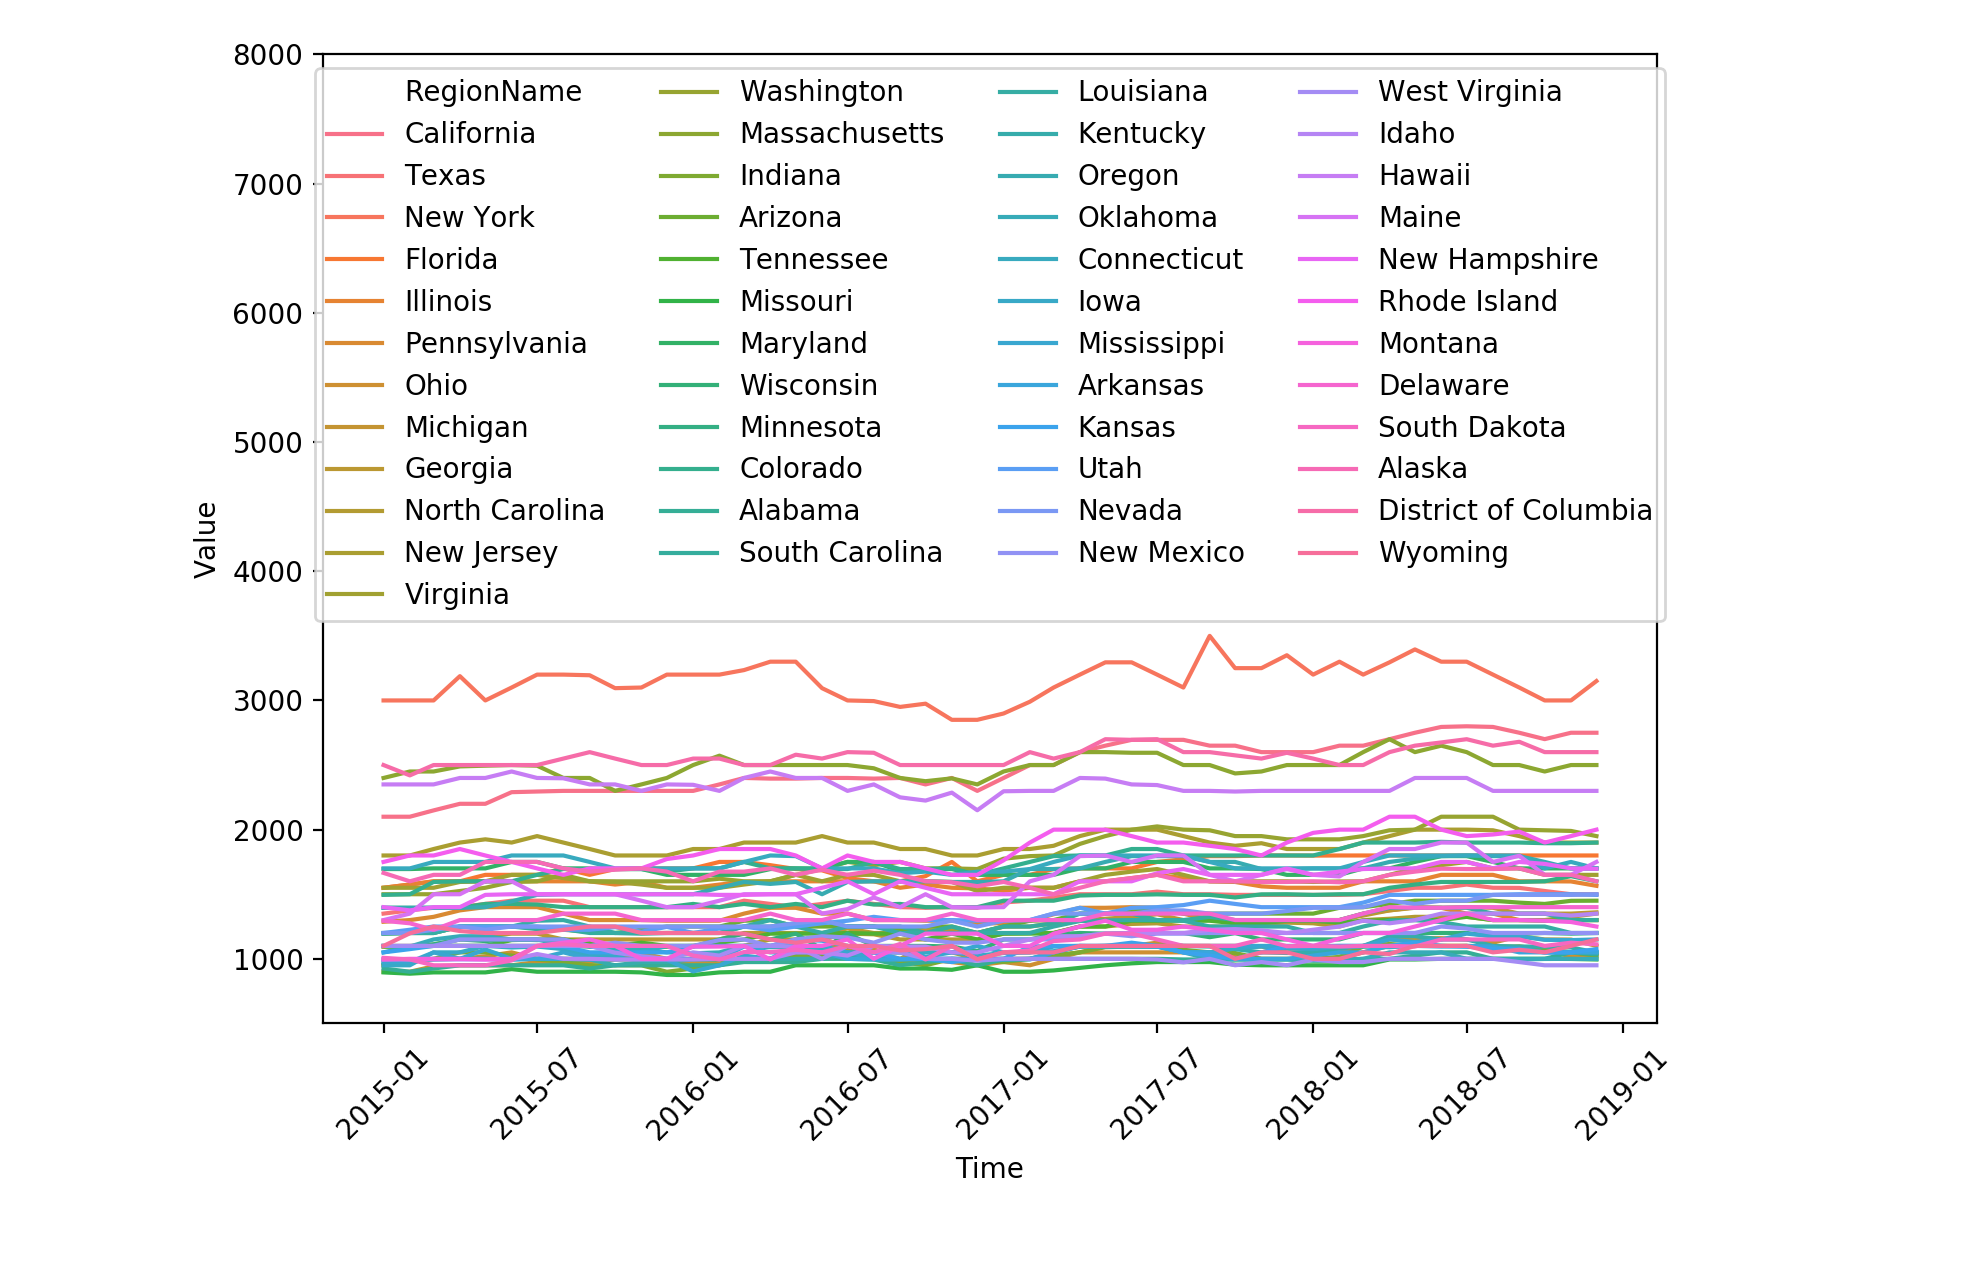

/Users/richagautam/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [28]:
%matplotlib notebook

#Plot the change in rent from Jan 2016 to Dec 2017 for each state
sns.lineplot(x="Time", y="Value", data=all_homes_long, hue='RegionName', legend='full')
plt.xticks(rotation=45)

# Move the legend to an empty part of the plot
plt.legend(loc='upper center', ncol=4)
plt.ylim(500, 8000)
plt.show()
plt.tight_layout()

In [7]:
contiguous_usa = gpd.read_file('cb_2018_us_state_20m/cb_2018_us_state_20m.shp')
contiguous_usa.columns = ['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'RegionName', 'LSAD',
       'ALAND', 'AWATER', 'geometry']

contiguous_usa.head()


,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,RegionName,LSAD,ALAND,AWATER,geometry
0,24,01714934,0400000US24,24,MD,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ..."
1,19,01779785,0400000US19,19,IA,Iowa,00,144661267977,1084180812,"POLYGON ((-96.62187 42.77925, -96.57794 42.827..."
2,10,01779781,0400000US10,10,DE,Delaware,00,5045925646,1399985648,"POLYGON ((-75.77379 39.72220, -75.75323 39.757..."
3,39,01085497,0400000US39,39,OH,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ..."
4,42,01779798,0400000US42,42,PA,Pennsylvania,00,115884442321,3394589990,"POLYGON ((-80.51989 40.90666, -80.51964 40.987..."


In [8]:
average_median_value = all_homes_long.groupby(['Year', 'RegionName'])['Value'].mean()
average_median_value = average_median_value.reset_index()
average_median_value.head()

,Year,RegionName,Value
0,2015,Alabama,939.583333
1,2015,Alaska,1687.916667
2,2015,Arizona,1224.583333
3,2015,Arkansas,998.333333
4,2015,California,2236.166667


In [9]:
df_2015 = pd.merge(contiguous_usa, average_median_value.loc[average_median_value['Year']==2015], on="RegionName", suffixes=("_shape", ""))
df_2015 = df_2015.loc[~df_2015['RegionName'].isin(['Puerto Rico', 'Nebraska', 'North Dakota','Hawaii', 'Alaska'])]
df_2015



,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,RegionName,LSAD,ALAND,AWATER,geometry,Year,Value
0,24,01714934,0400000US24,24,MD,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ...",2015,1702.500000
1,19,01779785,0400000US19,19,IA,Iowa,00,144661267977,1084180812,"POLYGON ((-96.62187 42.77925, -96.57794 42.827...",2015,1046.458333
2,10,01779781,0400000US10,10,DE,Delaware,00,5045925646,1399985648,"POLYGON ((-75.77379 39.72220, -75.75323 39.757...",2015,1303.750000
3,39,01085497,0400000US39,39,OH,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ...",2015,1003.041667
4,42,01779798,0400000US42,42,PA,Pennsylvania,00,115884442321,3394589990,"POLYGON ((-80.51989 40.90666, -80.51964 40.987...",2015,1336.000000
5,53,01779804,0400000US53,53,WA,Washington,00,172112588220,12559278850,"MULTIPOLYGON (((-123.23715 48.68347, -123.0704...",2015,1568.333333
6,01,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"POLYGON ((-88.46866 31.89386, -88.46866 31.933...",2015,939.583333
7,05,00068085,0400000US05,05,AR,Arkansas,00,134768872727,2962859592,"POLYGON ((-94.61792 36.49941, -94.36120 36.499...",2015,998.333333
8,35,00897535,0400000US35,35,NM,New Mexico,00,314196306401,728776523,"POLYGON ((-109.04919 31.79655, -109.04830 32.0...",2015,1122.916667
9,48,01779801,0400000US48,48,TX,Texas,00,676653171537,19006305260,"POLYGON ((-106.62345 31.91403, -106.63011 31.9...",2015,1407.916667


In [10]:
df_2016 = pd.merge(contiguous_usa, average_median_value.loc[average_median_value['Year']==2016], on="RegionName", suffixes=("_shape", ""))
df_2016 = df_2016.loc[~df_2016['RegionName'].isin(['Puerto Rico', 'Nebraska', 'North Dakota', 'Hawaii', 'Alaska'])]
df_2016


,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,RegionName,LSAD,ALAND,AWATER,geometry,Year,Value
0,24,01714934,0400000US24,24,MD,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ...",2016,1688.750000
1,19,01779785,0400000US19,19,IA,Iowa,00,144661267977,1084180812,"POLYGON ((-96.62187 42.77925, -96.57794 42.827...",2016,1069.791667
2,10,01779781,0400000US10,10,DE,Delaware,00,5045925646,1399985648,"POLYGON ((-75.77379 39.72220, -75.75323 39.757...",2016,1312.500000
3,39,01085497,0400000US39,39,OH,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ...",2016,1037.500000
4,42,01779798,0400000US42,42,PA,Pennsylvania,00,115884442321,3394589990,"POLYGON ((-80.51989 40.90666, -80.51964 40.987...",2016,1324.583333
5,53,01779804,0400000US53,53,WA,Washington,00,172112588220,12559278850,"MULTIPOLYGON (((-123.23715 48.68347, -123.0704...",2016,1673.750000
6,01,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"POLYGON ((-88.46866 31.89386, -88.46866 31.933...",2016,974.166667
7,05,00068085,0400000US05,05,AR,Arkansas,00,134768872727,2962859592,"POLYGON ((-94.61792 36.49941, -94.36120 36.499...",2016,1019.166667
8,35,00897535,0400000US35,35,NM,New Mexico,00,314196306401,728776523,"POLYGON ((-109.04919 31.79655, -109.04830 32.0...",2016,1142.083333
9,48,01779801,0400000US48,48,TX,Texas,00,676653171537,19006305260,"POLYGON ((-106.62345 31.91403, -106.63011 31.9...",2016,1413.708333


In [11]:
df_2017 = pd.merge(contiguous_usa, average_median_value.loc[average_median_value['Year']==2017], on="RegionName", suffixes=("_shape", ""))
df_2017 = df_2017.loc[~df_2017['RegionName'].isin(['Puerto Rico', 'Nebraska', 'North Dakota', 'Hawaii', 'Alaska'])]
df_2017


,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,RegionName,LSAD,ALAND,AWATER,geometry,Year,Value
0,24,01714934,0400000US24,24,MD,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ...",2017,1695.416667
1,19,01779785,0400000US19,19,IA,Iowa,00,144661267977,1084180812,"POLYGON ((-96.62187 42.77925, -96.57794 42.827...",2017,1074.958333
2,10,01779781,0400000US10,10,DE,Delaware,00,5045925646,1399985648,"POLYGON ((-75.77379 39.72220, -75.75323 39.757...",2017,1320.833333
3,39,01085497,0400000US39,39,OH,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ...",2017,1020.750000
4,42,01779798,0400000US42,42,PA,Pennsylvania,00,115884442321,3394589990,"POLYGON ((-80.51989 40.90666, -80.51964 40.987...",2017,1337.500000
5,53,01779804,0400000US53,53,WA,Washington,00,172112588220,12559278850,"MULTIPOLYGON (((-123.23715 48.68347, -123.0704...",2017,1921.166667
6,01,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"POLYGON ((-88.46866 31.89386, -88.46866 31.933...",2017,997.500000
7,05,00068085,0400000US05,05,AR,Arkansas,00,134768872727,2962859592,"POLYGON ((-94.61792 36.49941, -94.36120 36.499...",2017,1045.000000
8,35,00897535,0400000US35,35,NM,New Mexico,00,314196306401,728776523,"POLYGON ((-109.04919 31.79655, -109.04830 32.0...",2017,1182.083333
9,48,01779801,0400000US48,48,TX,Texas,00,676653171537,19006305260,"POLYGON ((-106.62345 31.91403, -106.63011 31.9...",2017,1488.875000


In [12]:
df_2018 = pd.merge(contiguous_usa, average_median_value.loc[average_median_value['Year']==2018], on="RegionName", suffixes=("_shape", ""))
df_2018 = df_2018.loc[~df_2018['RegionName'].isin(['Puerto Rico', 'Nebraska', 'North Dakota', 'Hawaii', 'Alaska'])]
df_2018


,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,RegionName,LSAD,ALAND,AWATER,geometry,Year,Value
0,24,01714934,0400000US24,24,MD,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ...",2018,1715.833333
1,19,01779785,0400000US19,19,IA,Iowa,00,144661267977,1084180812,"POLYGON ((-96.62187 42.77925, -96.57794 42.827...",2018,1080.416667
2,10,01779781,0400000US10,10,DE,Delaware,00,5045925646,1399985648,"POLYGON ((-75.77379 39.72220, -75.75323 39.757...",2018,1378.333333
3,39,01085497,0400000US39,39,OH,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ...",2018,1060.750000
4,42,01779798,0400000US42,42,PA,Pennsylvania,00,115884442321,3394589990,"POLYGON ((-80.51989 40.90666, -80.51964 40.987...",2018,1334.916667
5,53,01779804,0400000US53,53,WA,Washington,00,172112588220,12559278850,"MULTIPOLYGON (((-123.23715 48.68347, -123.0704...",2018,2002.500000
6,01,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"POLYGON ((-88.46866 31.89386, -88.46866 31.933...",2018,1015.000000
7,05,00068085,0400000US05,05,AR,Arkansas,00,134768872727,2962859592,"POLYGON ((-94.61792 36.49941, -94.36120 36.499...",2018,1067.916667
8,35,00897535,0400000US35,35,NM,New Mexico,00,314196306401,728776523,"POLYGON ((-109.04919 31.79655, -109.04830 32.0...",2018,1207.000000
9,48,01779801,0400000US48,48,TX,Texas,00,676653171537,19006305260,"POLYGON ((-106.62345 31.91403, -106.63011 31.9...",2018,1526.166667


In [19]:
# Input GeoJSON source that contains features for plotting
geosource_2015 = GeoJSONDataSource(geojson = df_2015.to_json())
geosource_2016 = GeoJSONDataSource(geojson = df_2016.to_json())
geosource_2017 = GeoJSONDataSource(geojson = df_2017.to_json())
geosource_2018 = GeoJSONDataSource(geojson = df_2018.to_json())

GeoJSONDataSource(id='1172', ...)

In [13]:
## Plot Median Rent for 2015
# Define color palettes
palette = brewer['BuGn'][8]
palette = palette[::-1] # reverse order of colors so higher values have darker colors

# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 4000)

# Define custom tick labels for color bar.
tick_labels = {'0': '0', '500': '500',
 '1000':'1000', '1500':'1500',
 '2000':'2000', '2500':'2500',
 '3000':'3000', '3500':'3500',
 '4000':'4000+'}

# Create color bar.
color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 8,
                     width = 500, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'horizontal',
                     major_label_overrides = tick_labels)

# Create figure object.
p_2015 = figure(title = 'Median Rental Prices, 2015', 
           plot_height = 600, plot_width = 950, 
           toolbar_location = 'below',
           tools = "pan, wheel_zoom, box_zoom, reset")
p_2015.xgrid.grid_line_color = None
p_2015.ygrid.grid_line_color = None

# Add patch renderer to figure.
states = p_2015.patches('xs','ys', source = geosource_2015,
                   fill_color = {'field' :'Value',
                                 'transform' : color_mapper},
                   line_color = 'gray', 
                   line_width = 0.25, 
                   fill_alpha = 1)

# Create hover tool
p_2015.add_tools(HoverTool(renderers = [states],
                      tooltips = [('State','@RegionName'),
                               ('Median Rent','@Value{int}')]))
# Specify layout
p_2015.add_layout(color_bar, 'below')
show(p_2015)


In [15]:
## Plot Median Rent for 2016
# Define color palettes
palette = brewer['BuGn'][8]
palette = palette[::-1] # reverse order of colors so higher values have darker colors

# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 4000)

# Define custom tick labels for color bar.
tick_labels = {'0': '0', '500': '500',
 '1000':'1000', '1500':'1500',
 '2000':'2000', '2500':'2500',
 '3000':'3000', '3500':'3500',
 '4000':'4000+'}

# Create color bar.
color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 8,
                     width = 500, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'horizontal',
                     major_label_overrides = tick_labels)

# Create figure object.
p_2016 = figure(title = 'Median Rental Prices, 2016', 
           plot_height = 600, plot_width = 950, 
           toolbar_location = 'below',
           tools = "pan, wheel_zoom, box_zoom, reset")
p_2016.xgrid.grid_line_color = None
p_2016.ygrid.grid_line_color = None

# Add patch renderer to figure.
states = p_2016.patches('xs','ys', source = geosource_2016,
                   fill_color = {'field' :'Value',
                                 'transform' : color_mapper},
                   line_color = 'gray', 
                   line_width = 0.25, 
                   fill_alpha = 1)

# Create hover tool
p_2016.add_tools(HoverTool(renderers = [states],
                      tooltips = [('State','@RegionName'),
                               ('Median Rent','@Value{int}')]))
# Specify layout
p_2016.add_layout(color_bar, 'below')
show(p_2016)


In [14]:
## Plot Median Rent for 2017
# Define color palettes
palette = brewer['BuGn'][8]
palette = palette[::-1] # reverse order of colors so higher values have darker colors

# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 4000)

# Define custom tick labels for color bar.
tick_labels = {'0': '0', '500': '500',
 '1000':'1000', '1500':'1500',
 '2000':'2000', '2500':'2500',
 '3000':'3000', '3500':'3500',
 '4000':'4000+'}

# Create color bar.
color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 8,
                     width = 500, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'horizontal',
                     major_label_overrides = tick_labels)

# Create figure object.
p_2017 = figure(title = 'Median Rental Prices, 2017', 
           plot_height = 600, plot_width = 950, 
           toolbar_location = 'below',
           tools = "pan, wheel_zoom, box_zoom, reset")
p_2017.xgrid.grid_line_color = None
p_2017.ygrid.grid_line_color = None

# Add patch renderer to figure.
states = p_2017.patches('xs','ys', source = geosource_2017,
                   fill_color = {'field' :'Value',
                                 'transform' : color_mapper},
                   line_color = 'gray', 
                   line_width = 0.25, 
                   fill_alpha = 1)

# Create hover tool
p_2017.add_tools(HoverTool(renderers = [states],
                      tooltips = [('State','@RegionName'),
                               ('Median Rent','@Value{int}')]))
# Specify layout
p_2017.add_layout(color_bar, 'below')
show(p_2017)


In [16]:
## Plot Median Rent for 2018
# Define color palettes
palette = brewer['BuGn'][8]
palette = palette[::-1] # reverse order of colors so higher values have darker colors

# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 4000)

# Define custom tick labels for color bar.
tick_labels = {'0': '0', '500': '500',
 '1000':'1000', '1500':'1500',
 '2000':'2000', '2500':'2500',
 '3000':'3000', '3500':'3500',
 '4000':'4000+'}

# Create color bar.
color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 8,
                     width = 500, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'horizontal',
                     major_label_overrides = tick_labels)

# Create figure object.
p_2018 = figure(title = 'Median Rental Prices, 2018', 
           plot_height = 600, plot_width = 950, 
           toolbar_location = 'below',
           tools = "pan, wheel_zoom, box_zoom, reset")
p_2018.xgrid.grid_line_color = None
p_2018.ygrid.grid_line_color = None

# Add patch renderer to figure.
states = p_2018.patches('xs','ys', source = geosource_2018,
                   fill_color = {'field' :'Value',
                                 'transform' : color_mapper},
                   line_color = 'gray', 
                   line_width = 0.25, 
                   fill_alpha = 1)

# Create hover tool
p_2018.add_tools(HoverTool(renderers = [states],
                      tooltips = [('State','@RegionName'),
                               ('Median Rent','@Value{int}')]))
# Specify layout
p_2018.add_layout(color_bar, 'below')
show(p_2018)

In [20]:
## Plot Median Rent change between 2017 and 2016
df_delta_1716 = pd.merge(average_median_value.loc[average_median_value['Year']==2016][['RegionName','Year','Value']], 
                    average_median_value.loc[average_median_value['Year']==2017][['RegionName','Year','Value']], 
                    on="RegionName", suffixes=("_2016", "_2017"))

df_delta_1716['Change'] = df_delta_1716['Value_2017'] - df_delta_1716['Value_2016']

df_delta_1716 = pd.merge(contiguous_usa, df_delta_1716, on="RegionName", suffixes=("_shape", ""))
df_delta_1716 = df_delta_1716.loc[~df_delta_1716['RegionName'].isin(['Puerto Rico', 'Nebraska', 'North Dakota', 'Hawaii', 'Alaska'])]
del df_delta_1716['Year_2016']
del df_delta_1716['Year_2017']
del df_delta_1716['Value_2016']
del df_delta_1716['Value_2017']

df_delta_1716.head()


,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,RegionName,LSAD,ALAND,AWATER,geometry,Change
0,24,01714934,0400000US24,24,MD,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ...",6.666667
1,19,01779785,0400000US19,19,IA,Iowa,00,144661267977,1084180812,"POLYGON ((-96.62187 42.77925, -96.57794 42.827...",5.166667
2,10,01779781,0400000US10,10,DE,Delaware,00,5045925646,1399985648,"POLYGON ((-75.77379 39.72220, -75.75323 39.757...",8.333333
3,39,01085497,0400000US39,39,OH,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ...",-16.750000
4,42,01779798,0400000US42,42,PA,Pennsylvania,00,115884442321,3394589990,"POLYGON ((-80.51989 40.90666, -80.51964 40.987...",12.916667


In [21]:
#Create geosource file
geosource_1716 = GeoJSONDataSource(geojson = df_delta_1716.to_json())

In [22]:
# Define color palettes
palette = brewer['RdBu'][8]
palette = palette[::-1] # reverse order of colors so higher values have darker colors

# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = -100, high = 300)

# Define custom tick labels for color bar.
tick_labels = {'-100': '-100', '-50': '-50',
 '0':'0', '50':'50',
 '100':'100', '150':'150',
 '200':'200', '250':'250',
 '300':'300+'}

# Create color bar.
color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 8,
                     width = 500, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'horizontal',
                     major_label_overrides = tick_labels)

# Create figure object.
p_1716 = figure(title = 'Change in Rental Prices, 2016-2017', 
           plot_height = 600, plot_width = 950, 
           toolbar_location = 'below',
           tools = "pan, wheel_zoom, box_zoom, reset")
p_1716.xgrid.grid_line_color = None
p_1716.ygrid.grid_line_color = None

# Add patch renderer to figure.
states = p_1716.patches('xs','ys', source = geosource_1716,
                   fill_color = {'field' :'Value',
                                 'transform' : color_mapper},
                   line_color = 'gray', 
                   line_width = 0.25, 
                   fill_alpha = 1)

# Create hover tool
p_1716.add_tools(HoverTool(renderers = [states],
                      tooltips = [('State','@RegionName'),
                               ('Median Rent Change','@Change{int}')]))
# Specify layout
p_1716.add_layout(color_bar, 'below')
show(p_1716)


In [23]:
## Plot Median Rent change between 2017 and 2016
df_delta_1615 = pd.merge(average_median_value.loc[average_median_value['Year']==2015][['RegionName','Year','Value']], 
                    average_median_value.loc[average_median_value['Year']==2016][['RegionName','Year','Value']], 
                    on="RegionName", suffixes=("_2015", "_2016"))

df_delta_1615['Change'] = df_delta_1615['Value_2016'] - df_delta_1615['Value_2015']

df_delta_1615 = pd.merge(contiguous_usa, df_delta_1615, on="RegionName", suffixes=("_shape", ""))
df_delta_1615 = df_delta_1615.loc[~df_delta_1615['RegionName'].isin(['Puerto Rico', 'Nebraska', 'North Dakota', 'Hawaii', 'Alaska'])]
del df_delta_1615['Year_2015']
del df_delta_1615['Year_2016']
del df_delta_1615['Value_2015']
del df_delta_1615['Value_2016']

df_delta_1615.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,RegionName,LSAD,ALAND,AWATER,geometry,Change
0,24,01714934,0400000US24,24,MD,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ...",-13.750000
1,19,01779785,0400000US19,19,IA,Iowa,00,144661267977,1084180812,"POLYGON ((-96.62187 42.77925, -96.57794 42.827...",23.333333
2,10,01779781,0400000US10,10,DE,Delaware,00,5045925646,1399985648,"POLYGON ((-75.77379 39.72220, -75.75323 39.757...",8.750000
3,39,01085497,0400000US39,39,OH,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ...",34.458333
4,42,01779798,0400000US42,42,PA,Pennsylvania,00,115884442321,3394589990,"POLYGON ((-80.51989 40.90666, -80.51964 40.987...",-11.416667


In [24]:
#Create geosource file
geosource_1615 = GeoJSONDataSource(geojson = df_delta_1615.to_json())


In [25]:
# Define color palettes
palette = brewer['RdBu'][8]
palette = palette[::-1] # reverse order of colors so higher values have darker colors

# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = -100, high = 300)

# Define custom tick labels for color bar.
tick_labels = {'-100': '-100', '-50': '-50',
 '0':'0', '50':'50',
 '100':'100', '150':'150',
 '200':'200', '250':'250',
 '300':'300+'}

# Create color bar.
color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 8,
                     width = 500, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'horizontal',
                     major_label_overrides = tick_labels)

# Create figure object.
p_1615 = figure(title = 'Change in Rental Prices, 2015-2016', 
           plot_height = 600, plot_width = 950, 
           toolbar_location = 'below',
           tools = "pan, wheel_zoom, box_zoom, reset")
p_1615.xgrid.grid_line_color = None
p_1615.ygrid.grid_line_color = None

# Add patch renderer to figure.
states = p_1615.patches('xs','ys', source = geosource_1615,
                   fill_color = {'field' :'Value',
                                 'transform' : color_mapper},
                   line_color = 'gray', 
                   line_width = 0.25, 
                   fill_alpha = 1)

# Create hover tool
p_1615.add_tools(HoverTool(renderers = [states],
                      tooltips = [('State','@RegionName'),
                               ('Median Rent Change','@Change{int}')]))
# Specify layout
p_1615.add_layout(color_bar, 'below')
show(p_1615)


In [26]:
## Plot Median Rent change between 2018 and 2015
df_delta_1815 = pd.merge(average_median_value.loc[average_median_value['Year']==2015][['RegionName','Year','Value']], 
                    average_median_value.loc[average_median_value['Year']==2018][['RegionName','Year','Value']], 
                    on="RegionName", suffixes=("_2015", "_2018"))

df_delta_1815['Change'] = df_delta_1815['Value_2018'] - df_delta_1815['Value_2015']

df_delta_1815 = pd.merge(contiguous_usa, df_delta_1815, on="RegionName", suffixes=("_shape", ""))
df_delta_1815 = df_delta_1815.loc[~df_delta_1815['RegionName'].isin(['Puerto Rico', 'Nebraska', 'North Dakota', 'Hawaii', 'Alaska'])]
del df_delta_1815['Year_2015']
del df_delta_1815['Year_2018']
del df_delta_1815['Value_2015']
del df_delta_1815['Value_2018']

df_delta_1815.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,RegionName,LSAD,ALAND,AWATER,geometry,Change
0,24,01714934,0400000US24,24,MD,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ...",13.333333
1,19,01779785,0400000US19,19,IA,Iowa,00,144661267977,1084180812,"POLYGON ((-96.62187 42.77925, -96.57794 42.827...",33.958333
2,10,01779781,0400000US10,10,DE,Delaware,00,5045925646,1399985648,"POLYGON ((-75.77379 39.72220, -75.75323 39.757...",74.583333
3,39,01085497,0400000US39,39,OH,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ...",57.708333
4,42,01779798,0400000US42,42,PA,Pennsylvania,00,115884442321,3394589990,"POLYGON ((-80.51989 40.90666, -80.51964 40.987...",-1.083333


In [27]:
#Create geosource file
geosource_1815 = GeoJSONDataSource(geojson = df_delta_1815.to_json())


In [28]:
# Define color palettes
palette = brewer['RdBu'][8]
palette = palette[::-1] # reverse order of colors so higher values have darker colors

# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = -100, high = 300)

# Define custom tick labels for color bar.
tick_labels = {'-100': '-100', '-50': '-50',
 '0':'0', '50':'50',
 '100':'100', '150':'150',
 '200':'200', '250':'250',
 '300':'300+'}

# Create color bar.
color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 8,
                     width = 500, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'horizontal',
                     major_label_overrides = tick_labels)

# Create figure object.
p_1815 = figure(title = 'Change in Rental Prices, 2015-2018', 
           plot_height = 600, plot_width = 950, 
           toolbar_location = 'below',
           tools = "pan, wheel_zoom, box_zoom, reset")
p_1815.xgrid.grid_line_color = None
p_1815.ygrid.grid_line_color = None

# Add patch renderer to figure.
states = p_1815.patches('xs','ys', source = geosource_1815,
                   fill_color = {'field' :'Value',
                                 'transform' : color_mapper},
                   line_color = 'gray', 
                   line_width = 0.25, 
                   fill_alpha = 1)

# Create hover tool
p_1815.add_tools(HoverTool(renderers = [states],
                      tooltips = [('State','@RegionName'),
                               ('Median Rent Change','@Change{int}')]))
# Specify layout
p_1815.add_layout(color_bar, 'below')
show(p_1815)

In [29]:
average_median_value.loc[average_median_value['Year'] == 2015].nlargest(3, 'Value')

,Year,RegionName,Value
31,2015,New York,3106.500000
8,2015,District of Columbia,2510.000000
21,2015,Massachusetts,2427.458333


In [30]:
average_median_value.loc[average_median_value['Year'] == 2016].nlargest(3, 'Value')

,Year,RegionName,Value
79,2016,New York,3079.166667
56,2016,District of Columbia,2535.416667
69,2016,Massachusetts,2464.125000


In [31]:
average_median_value.loc[average_median_value['Year'] == 2017].nlargest(3, 'Value')

,Year,RegionName,Value
127,2017,New York,3202.416667
104,2017,District of Columbia,2605.416667
100,2017,California,2602.916667


In [32]:
average_median_value.loc[average_median_value['Year'] == 2018].nlargest(3, 'Value')

,Year,RegionName,Value
175,2018,New York,3203.333333
148,2018,California,2724.208333
152,2018,District of Columbia,2608.750000


In [33]:
average_median_value.loc[average_median_value['Year'] == 2015].nsmallest(3, 'Value')

,Year,RegionName,Value
25,2015,Missouri,896.250000
0,2015,Alabama,939.583333
22,2015,Michigan,956.833333


In [34]:
average_median_value.loc[average_median_value['Year'] == 2016].nsmallest(3, 'Value')

,Year,RegionName,Value
73,2016,Missouri,923.750000
48,2016,Alabama,974.166667
62,2016,Indiana,990.166667


In [35]:
average_median_value.loc[average_median_value['Year'] == 2017].nsmallest(3, 'Value')

,Year,RegionName,Value
121,2017,Missouri,944.583333
141,2017,West Virginia,986.875000
96,2017,Alabama,997.500000


In [36]:
average_median_value.loc[average_median_value['Year'] == 2018].nsmallest(3, 'Value')

,Year,RegionName,Value
189,2018,West Virginia,980.833333
169,2018,Missouri,986.166667
178,2018,Oklahoma,1011.083333


In [ ]:
#Enter any hubs we want to filter by
hubs = ['New York', 'California', 'District of Columbia', 'Massachusetts', 
        'Missouri', 'Michigan', 'West Virginia', 'Alabama', 'Indiana']

